In [1]:
# Python libraries needed to run the TDA based method package ##

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import MultiPoint
import random
import math
import shapely.affinity
from scipy.spatial import distance
from scipy.spatial import ConvexHull
import geopandas as gpd
import matplotlib.pyplot as plt
import utm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import time
#import gdal
from pyproj import Proj,transform
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy as np
import elevation
from osgeo import gdal
import time
import pandas as pd
from scipy.interpolate import griddata
import random 
from gtda.plotting import plot_diagram
from gtda.homology import VietorisRipsPersistence,SparseRipsPersistence,EuclideanCechPersistence
from gtda.diagrams import Amplitude,NumberOfPoints,PersistenceEntropy
from gtda.diagrams import Filtering
import warnings
warnings.filterwarnings("ignore")


def read_shapefiles (path_filename):
    
    """
    function to read the shapefile from the local file path of landslide inventory
    
  
    Parameters:
         :path_filename (str): path to local inventory shapefiles
    
    
    Returns:
         read shapefile from file path
    
    """
    
    return gpd.read_file(path_filename)


def min_max_inventory(poly_data,lon_res,lat_res):

    """
    function to calculate the bounding box coordinates of complete landslide inventory


    Parameters:
          :poly_data (str): landslide polygon data in an inventory
          :lon_res (float): longitude resolution
          :lat_res (float): latitude resolution

    
    Returns:
         bounding box coordinates of landslide inventory region
    
    """
    data_coord=[]
    for l in range((np.shape(poly_data)[0])):
        if poly_data['geometry'][l].geom_type=='Polygon':
            poly_xy=np.asarray(poly_data['geometry'][l].exterior.coords)  ## (lon,lat)
            min_landslide_lon,max_landslide_lon=np.min(poly_xy[:,0]),np.max(poly_xy[:,0])
            min_landslide_lat,max_landslide_lat=np.min(poly_xy[:,1]),np.max(poly_xy[:,1])
            data_coord.append([min_landslide_lon,max_landslide_lon,min_landslide_lat,max_landslide_lat])
    data_coord=np.asarray(data_coord) 
    kk=20
    
    return (np.min(data_coord[:,0])-kk*lon_res, np.max(data_coord[:,1])+kk*lon_res,np.min(data_coord[:,2])+kk*lat_res,np.max(data_coord[:,3])-kk*lat_res)


def latlon_to_eastnorth (lonlat_polydata):
    
    """ 
    function to convert the (longitude latitude) coordinates of polygons to (easting, northing) coordinates
    
    
    Parameters:
          :lonllat_polydata (array_like): 
                             longitude and latitude coordinates data
                      
    Returns:
            (array_like)
            easting and northing coordinates of landslide polygon data when polygon data has longitude latitude coordinates 

    
     
    """
     
    east_north_polydata=[]
    for i in range(np.shape(lonlat_polydata)[0]):
        u = utm.from_latlon(lonlat_polydata[i][1], lonlat_polydata[i][0])   ### (lat,lon) to (east,north)
        east_north_polydata.append([u[0],u[1]])
    east_north_polydata=np.asarray(east_north_polydata) 
    return  east_north_polydata 

def download_dem(poly_data,dem_location,inventory_name):

    """
    function to download the DEM corresponding to inventory region

    Parameters:
         :poly_data (str) : landslide polygon data in an inventory
         :dem_location (str): provide the path where user wants to download DEM
         :inventory_name (str): inventory_name to save the dem file

    Returns:
        (str) downloaded DEM file location for input landslide inventory
          
    """
    
    longitude_min,longitude_max,latitude_min,latitude_max=min_max_inventory(poly_data,0.00,-0.00)

    total_number_of_tiles=(longitude_max-longitude_min)*(latitude_max-latitude_min)
    print('total number of tiles:',total_number_of_tiles)
    print("** Number of tiles should be less than 100 or depend on user device RAM **" )
    print('** only the folder location in dem_location option **')

    
    #inventory_name=input('**only tif name should be given')
    #inventory_name='inventory%s'%np.random.randint(0,1000)+'.tif'
    final_output_filename=dem_location+inventory_name
    if total_number_of_tiles<10:
       longitude_min,longitude_max=longitude_min-0.4,longitude_max+0.4
       latitude_min,latitude_max=latitude_min-0.4,latitude_max+0.4
       latitude_min,latitude_max
       print("less than 10 tiles") 
       elevation.clip(bounds=(longitude_min, latitude_min, longitude_max, latitude_max), output=final_output_filename)
       elevation.clean() 

    else:
        print('more than 10 tiles')
        latitude_width=latitude_max-latitude_min
        longitude_width=longitude_max-longitude_min

        add_latitude=3-latitude_width%3
        add_longitude=3-longitude_width%3

        latitude_max=latitude_max+add_latitude
        longitude_max=longitude_max+add_longitude

        latitude_width=(latitude_max-latitude_min)
        longitude_width=(longitude_max-longitude_min)
        t=0
        for j in range(0,latitude_width,3):
            for i in range(0,longitude_width,3):
                t=t+1
                output=dem_location+'inven_name%s.tif'%t
                elevation.clip(bounds=(longitude_min+i, latitude_max-j-3, longitude_min+i+3,latitude_max-j), output=output)    
                elevation.clean()

        NN=10800
        DEM_DATA=np.zeros((NN*latitude_width//3, NN*longitude_width//3),dtype='uint16')
        t=1
        X_0,Y_0=[],[]


        for i in range(latitude_width//3):
            for j in range(longitude_width//3):
                inv_name="inven_name%s.tif"%t
                data_name=dem_location+inv_name
                DEM = gdal.Open(data_name)
                x_0,x_res,_,y_0,_,y_res = DEM.GetGeoTransform()
                X_0.append(x_0),Y_0.append(y_0)
                print(x_0,x_res,_,y_0,_,y_res)
                #print(np.asarray(DEM))
                from PIL import Image
                #im = Image.open(data_name)
                #z = np.array(DEM.GetRasterBand().ReadAsArray())

                z=gdal.Dataset.ReadAsArray(DEM)
                DEM_DATA[(i*NN):(i*NN)+NN,(j*NN):(j*NN)+NN]=z
                t=t+1
                print(t)
        x_0=min(X_0)
        y_0=max(Y_0)
        time.sleep(180)
        #######################################################################################################
        geotransform = (x_0,x_res,0,y_0,0,y_res)
        driver = gdal.GetDriverByName('Gtiff')
        final_output_filename=dem_location+inventory_name
        dataset = driver.Create(final_output_filename, DEM_DATA.shape[1], DEM_DATA.shape[0], 1, gdal.GDT_Float32)
        dataset.SetGeoTransform(geotransform)
        dataset.GetRasterBand(1).WriteArray(DEM_DATA)
        #################################################################################################    
    time.sleep(180)
    return  final_output_filename 


def make_3d_polygons(poly_data,dem_location,inventory_name,kk):

    """    
    function to get 3D point cloud from 2D shape of landslide

    Parameters:
       :poly_data (str): polygons shapefile
       :dem_location (str): path of dem file
       :inventory_name (str): path of dem file
       :kk (int): kk=1 if user have already DEM corresponding to inventory region otherwise use any other number
   
    Returns:
       (array_like) 3D data of landslides
       
    """
    
    if kk==1:  
       DEM_FILE_NAME=dem_location+inventory_name
    else:
         DEM_FILE_NAME=download_dem(poly_data,dem_location,inventory_name)
    ############################################################################
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:3857')
    data=[]
    eleva_polyon=[]

    DEM = gdal.Open(DEM_FILE_NAME)
    lon_init,lon_res,_,lat_init,_,lat_res = DEM.GetGeoTransform()
    DEM_data=gdal.Dataset.ReadAsArray(DEM)
    #print(np.shape(DEM_data))

    lon_all=np.arange(lon_init,lon_init+np.shape(DEM_data)[1]*lon_res,lon_res)
    lat_all=np.arange(lat_init,lat_init+np.shape(DEM_data)[0]*lat_res,lat_res)
    
    #print (' ***  Upload Complete Shapefiles Of Landslides In Landslide Inventory ***')
    #print('*** Input should be a shapefiles of landslide polygons  *** ' )
    
    inv_lon_min,inv_lon_max,inv_lat_min,inv_lat_max=min_max_inventory(poly_data,lon_res,lat_res)
    indices_lon_dem_crop_inventory=np.argwhere((lon_all>inv_lon_min)&(lon_all<inv_lon_max))[:,0]
    indices_lat_dem_crop_inventory=np.argwhere((lat_all>inv_lat_min)&(lat_all<inv_lat_max))[:,0]

    min_indices_lon_dem_crop_inventory=np.min(indices_lon_dem_crop_inventory)
    max_indices_lon_dem_crop_inventory=np.max(indices_lon_dem_crop_inventory)

    min_indices_lat_dem_crop_inventory=np.min(indices_lat_dem_crop_inventory)
    max_indices_lat_dem_crop_inventory=np.max(indices_lat_dem_crop_inventory)
    
    DEM_data=DEM_data[min_indices_lat_dem_crop_inventory:max_indices_lat_dem_crop_inventory,
                          min_indices_lon_dem_crop_inventory:max_indices_lon_dem_crop_inventory]
    
    lon_all=lon_all[min_indices_lon_dem_crop_inventory:max_indices_lon_dem_crop_inventory]
    lat_all=lat_all[min_indices_lat_dem_crop_inventory:max_indices_lat_dem_crop_inventory]          ### check 
    
    for l in range((np.shape(poly_data)[0])):
        print(l)
    #for l in range(100):    
        if poly_data['geometry'][l].geom_type=='Polygon':
            #print(l)
            poly_xy=np.asarray(poly_data['geometry'][l].exterior.coords)  ## (lon,lat)
            ze_1=poly_xy
            if np.nanmin(ze_1) < 100:
                ze_1=latlon_to_eastnorth(ze_1)
                area_polygon=Polygon(ze_1).area
                
            if area_polygon>1000:    
                #print(area_polygon) 
          
                min_landslide_lon,max_landslide_lon=np.min(poly_xy[:,0]),np.max(poly_xy[:,0])
                min_landslide_lat,max_landslide_lat=np.min(poly_xy[:,1]),np.max(poly_xy[:,1])

                extra=10
                indices_lon_land=np.argwhere((lon_all>min_landslide_lon-extra*lon_res) & (lon_all<max_landslide_lon+extra*lon_res))[:,0]
                indices_lat_land=np.argwhere((lat_all>min_landslide_lat+extra*lat_res) & (lat_all<max_landslide_lat-extra*lat_res))[:,0]

                DEM_landslide_region_crop=DEM_data[np.min(indices_lat_land):np.max(indices_lat_land)+1,
                                                  np.min(indices_lon_land):np.max(indices_lon_land)+1] ############## check 

                lon_landslides_region=lon_all[indices_lon_land]
                lat_landslides_region=lat_all[indices_lat_land]

                ######## for landslide region interpolation #######
                lon_mesh,lat_mesh=np.meshgrid(lon_landslides_region,lat_landslides_region)
                lon_mesh,lat_mesh=lon_mesh.flatten(),lat_mesh.flatten()
                DEM_landslide_region_crop_=DEM_landslide_region_crop.flatten()


                lon_mesh_east,lat_mesh_north = transform(inProj,outProj,lon_mesh,lat_mesh)

                poly_xy[:,0],poly_xy[:,1] = transform(inProj,outProj,poly_xy[:,0],poly_xy[:,1])


                lon_mesh_east=np.reshape(lon_mesh_east,(np.shape(lon_mesh_east)[0],1))
                lat_mesh_north=np.reshape(lat_mesh_north,(np.shape(lat_mesh_north)[0],1))
                lonlat_mesh_eastnorth=np.hstack((lon_mesh_east,lat_mesh_north))

                xmin1,xmax1=np.min(poly_xy[:,0])-30,np.max(poly_xy[:,0])+30
                ymin1,ymax1=np.min(poly_xy[:,1])-30,np.max(poly_xy[:,1])+30
                k,total_grid=0,32
                xnew =np.linspace(xmin1-k, xmax1+k,total_grid)
                ynew =np.linspace(ymin1-k, ymax1+k,total_grid) 

                xneww,yneww=np.meshgrid(xnew,ynew)


                eleva_inter=griddata(lonlat_mesh_eastnorth, DEM_landslide_region_crop_,(xneww,yneww),method='cubic')
                eleva_poly=griddata(lonlat_mesh_eastnorth, DEM_landslide_region_crop_,(poly_xy[:,0],poly_xy[:,1]),method='cubic')
                poly_norm=(eleva_poly-np.min(eleva_poly))

                
                
                
                eleva_final=eleva_inter
                #eleva_norm=(eleva_final-np.min(eleva_final))/(np.max(eleva_final)-np.min(eleva_final))
                eleva_norm=eleva_final
                #######################################################################################################################
                polygon = Polygon(poly_xy)
                XNEW,YNEW=np.meshgrid(xnew,ynew)
                XNEW,YNEW=XNEW.flatten(),YNEW.flatten()
                combine_data=np.zeros((total_grid*total_grid,3))
                combine_data[:,0]=XNEW
                combine_data[:,1]=YNEW

                  #print('elevation')
                ELEVA_NORM=eleva_norm.flatten()
                combine_data[:,2]=ELEVA_NORM

                ##################################################################################################
                indices=[]
                for i in range(np.shape(combine_data)[0]):
                    point=Point(combine_data[i,0:2])
                    if polygon.contains(point)==True:
                       indices.append(i) 

                indices=np.asarray(indices)
                if np.shape(indices)[0]>0:
                    combine_data=combine_data[indices]
                    #combine_data[:,0]=(combine_data[:,0]-np.min(combine_data[:,0]))/(np.max(combine_data[:,0])-np.min(combine_data[:,0]))
                    #combine_data[:,1]=(combine_data[:,1]-np.min(combine_data[:,1]))/(np.max(combine_data[:,1])-np.min(combine_data[:,1]))
                    #combine_data[:,2]=(combine_data[:,2]-np.min(combine_data[:,2]))/(np.max(combine_data[:,2])-np.min(combine_data[:,2]))
                    
                    combine_data[:,0]=(combine_data[:,0]-np.min(combine_data[:,0]))
                    combine_data[:,1]=(combine_data[:,1]-np.min(combine_data[:,1]))
                    combine_data[:,2]=(combine_data[:,2]-np.min(combine_data[:,2]))
                    
                    data.append(combine_data)
                    #eleva_polyon.append([poly_xy[:,0]-np.min(combine_data[:,0]),poly_xy[:,1]-np.min(combine_data[:,1]),poly_norm])
                    a1=(poly_xy[:,0]-np.min(poly_xy[:,0]))/(np.max(poly_xy[:,0])-np.min(poly_xy[:,0]))
                    b1=(poly_xy[:,1]-np.min(poly_xy[:,1]))/(np.max(poly_xy[:,1])-np.min(poly_xy[:,1]))
                    c1=(poly_norm-np.min(poly_norm))/(np.max(poly_norm)-np.min(poly_norm))
                    a1=a1[:,np.newaxis]
                    b1=b1[:,np.newaxis]
                    c1=c1[:,np.newaxis]
                    
                    eleva_polyon.append(np.hstack((a1,b1,c1)))


    return eleva_polyon


def get_ml_features(data):

    """
    function to get machine learning features from 3D point cloud data

    Parameters:
         :data (array_like): 3D point cloud data of landslides
   
    Returns:
          Topological features corresponding to 3D point cloud data

    
    """
    
    homology_dimensions = [0, 1, 2]
    from gtda.homology import VietorisRipsPersistence,SparseRipsPersistence,EuclideanCechPersistence
    persistence = VietorisRipsPersistence(metric="euclidean",homology_dimensions=homology_dimensions,n_jobs=6,collapse_edges=True)
    data= persistence.fit_transform(data)
    data=Filtering(homology_dimensions=[0,1,2],epsilon=0.03).fit_transform(data)
    #data=Filtering(homology_dimensions=[0],epsilon=2).fit_transform(data)
   
    
    def average_lifetime(pers_diagrams_one):
        homology_dimensions = [0, 1, 2]
        persistence_diagram =pers_diagrams_one
        persistence_table = pd.DataFrame(persistence_diagram, columns=["birth", "death", "homology_dim"])
        persistence_table["lifetime"] = persistence_table["death"] - persistence_table["birth"] 
        life_avg_all_dims=[]

        for dims in homology_dimensions:
            avg_lifetime_one=persistence_table[persistence_table['homology_dim']==dims]['lifetime'].mean()
            life_avg_all_dims.append(avg_lifetime_one)
        life_avg_all_dims=np.asarray(life_avg_all_dims)
        life_avg_all_dims=life_avg_all_dims.flatten() 
        return life_avg_all_dims   

    metrics=["bottleneck", "wasserstein", "landscape",'heat','betti',"persistence_image","silhouette"]
    feature_all_data=[]
    for i in range(np.shape(data)[0]):
        if (i%2000)==0:
            print(i) 
        feature_total_one=[]
        persistant_one = data[i][None, :, :]
        
        persistence_entropy = PersistenceEntropy()
        feature_onemeasure_entrophy = persistence_entropy.fit_transform(persistant_one)
        feature_total_one.append(feature_onemeasure_entrophy)

        feature_onemeasure=NumberOfPoints().fit_transform(persistant_one)
        feature_total_one.append(feature_onemeasure)

        feature_onemeasure=average_lifetime(data[i])  
        feature_onemeasure=feature_onemeasure.reshape(1,3)
        feature_total_one.append(feature_onemeasure)

        for metric in metrics:
            feature_onemeasure=Amplitude(metric=metric).fit_transform(persistant_one)
            feature_total_one.append(feature_onemeasure)

        feature_total_one=np.asarray(feature_total_one)     
        feature_total_one=feature_total_one.flatten()

        feature_all_data.append(feature_total_one)
    feature_all_data=np.asarray(feature_all_data)  
    return feature_all_data    


In [2]:
# Italy features generated without interior point clouds
features_slide_landslide=np.load('Sample feature engineered data of Italy for testing/slide.npy')

features_dflow_landslide = np.load('Sample feature engineered data of Italy for testing/dflow.npy')

features_eflow_landslide = np.load('Sample feature engineered data of Italy for testing/eflow.npy')

features_complex_landslide=np.load('Sample feature engineered data of Italy for testing/complex.npy')

features_fall_landslide=np.load('Sample feature engineered data of Italy for testing/fall.npy')

In [18]:
label_slide=np.zeros((np.shape(features_slide_landslide)[0],1))
label_dflow=np.ones((np.shape(features_dflow_landslide)[0],1))
label_eflow=np.ones((np.shape(features_eflow_landslide)[0],1))*2
label_complex=np.ones((np.shape(features_complex_landslide)[0],1))*3
label_fall=np.ones((np.shape(features_fall_landslide)[0],1))*4

In [19]:
N=2000 # Choose the number of samples you want to train on.

In [20]:
data=np.vstack((features_slide_landslide[0:N],features_dflow_landslide[0:N],features_eflow_landslide[0:N],features_complex_landslide[0:N],features_fall_landslide[0:N]))
label=np.vstack((label_slide[0:N],label_dflow[0:N],label_eflow[0:N],label_complex[0:N],label_fall[0:N]))
print(np.shape(data),np.shape(label))

(10000, 30) (10000, 1)


In [21]:
false_data_ind=np.unique(np.argwhere(data>10000)[:,0])
len(false_data_ind)

0

In [22]:
real_data_ind=np.setdiff1d(np.arange(len(data)),false_data_ind)
len(real_data_ind)

10000

In [23]:
data=data[real_data_ind,:]
label=label[real_data_ind,:]

In [24]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix

feature=[]
for ee in range(10): 
    start_time = time.time()
    print(ee)
    Train,Test=[],[]
    Trainlabel,Testlabel=[],[]
    feato=[]
    kf = KFold(n_splits=10,shuffle=True)  
    for train_index, test_index in kf.split(data):
        Train.append(data[train_index,:])
        Test.append(data[test_index,:])
        Trainlabel.append(label[train_index])
        Testlabel.append(label[test_index])

    for k in range(10):
        Classifier = RandomForestClassifier(n_estimators=100) 
        scaler = StandardScaler()
        train_data = scaler.fit_transform( Train[k])
        test_data = scaler.transform(Test[k])
        Classifier.fit(train_data,np.ravel(Trainlabel[k] ))      
        y_pred = Classifier.predict(test_data)
        Featur_importance=Classifier.feature_importances_
        feato.append(Featur_importance)
    feature.append(np.average(np.asarray(feato),axis=0)) 
    print("--- %s seconds ---" % (time.time() - start_time))    
FEATURE_IMP=np.asarray(feature)
FEATURE_IMP=np.average(FEATURE_IMP,axis=0)  

0


--- 40.905935764312744 seconds ---
1
--- 41.263723850250244 seconds ---
2
--- 41.70707321166992 seconds ---
3
--- 41.83077383041382 seconds ---
4
--- 42.02686357498169 seconds ---
5
--- 42.550822019577026 seconds ---
6
--- 41.690346240997314 seconds ---
7
--- 41.384469747543335 seconds ---
8
--- 41.41784596443176 seconds ---
9
--- 42.03527045249939 seconds ---


In [25]:
#############################################################################################################
imp_features = np.array([ 7, 6, 12, 21, 22, 10]) # Most important features
DATA=data[:,imp_features]

In [26]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


feature=[]

for ee in range(5): 
    
    start_time = time.time()
    print(ee)
    Train,Test=[],[]
    Trainlabel,Testlabel=[],[]
    feato=[]
    kf = KFold(n_splits=10,shuffle=True)  
    for train_index, test_index in kf.split(DATA):
        Train.append(data[train_index,:])
        Test.append(data[test_index,:])
        Trainlabel.append(label[train_index])
        Testlabel.append(label[test_index])

    for k in range(10):
        Classifier = RandomForestClassifier(n_estimators=100,max_depth=None) 
        scaler = StandardScaler()
        train_data = scaler.fit_transform(Train[k])
        test_data = scaler.transform(Test[k])
        Classifier.fit(train_data,np.ravel(Trainlabel[k]))      
        y_pred = Classifier.predict(test_data)
        print(accuracy_score(Testlabel[k],y_pred ))

        
        Featur_importance=Classifier.feature_importances_
        feato.append(Featur_importance)
    feature.append(np.average(np.asarray(feato),axis=0)) 
    print("--- %s seconds ---" % (time.time() - start_time))    
FEATURE_IMP=np.asarray(feature)
FEATURE_IMP=np.average(FEATURE_IMP,axis=0)  

0
0.834
0.839
0.849
0.819
0.844
0.84
0.83
0.858
0.83
0.847
--- 41.5283739566803 seconds ---
1
0.847
0.839
0.851
0.839
0.829
0.858
0.83
0.842
0.838
0.852
--- 41.46789765357971 seconds ---
2
0.829
0.839
0.833
0.836
0.841
0.838
0.83
0.861
0.819
0.842
--- 41.6937530040741 seconds ---
3
0.857
0.837
0.844
0.833
0.823
0.817
0.83
0.849
0.848
0.842
--- 41.6562294960022 seconds ---
4
0.861
0.849
0.818
0.821
0.845
0.83
0.837
0.853
0.851
0.838
--- 41.48610329627991 seconds ---


In [27]:
aa=confusion_matrix(Testlabel[k],y_pred)
aa

array([[182,  14,   1,   2,   1],
       [ 19, 154,   0,  13,   2],
       [  0,   1, 191,  10,   9],
       [  6,  25,  11, 140,  12],
       [  2,   9,  20,   5, 171]], dtype=int64)

In [28]:
(aa[0,0]/np.sum(aa[0,:]))*100

91.0

In [29]:
(aa[1,1]/np.sum(aa[1,:]))*100

81.91489361702128

In [30]:
(aa[2,2]/np.sum(aa[2,:]))*100

90.52132701421802

In [31]:
(aa[3,3]/np.sum(aa[3,:]))*100

72.16494845360825

In [32]:
(aa[4,4]/np.sum(aa[4,:]))*100

82.6086956521739

In [33]:
from sklearn.metrics import f1_score
f1_score(Testlabel[k],y_pred,average='macro')

0.835572140994642

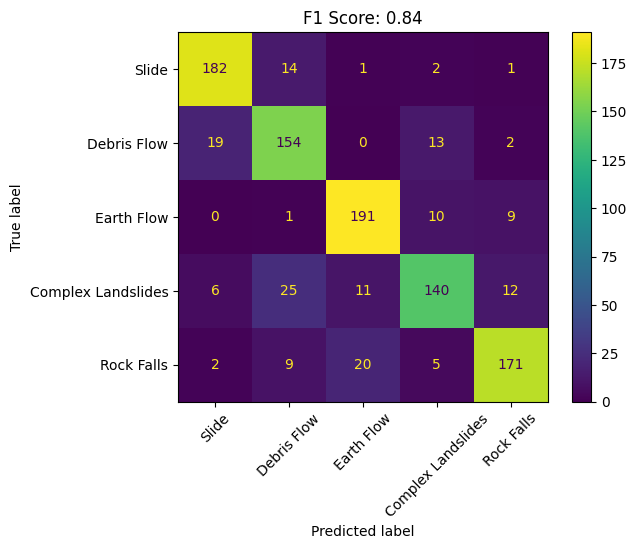

In [34]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Testlabel[k], y_pred)
f1 = f1_score(Testlabel[k], y_pred, average='macro')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
                                                                    'Slide', 'Debris Flow', 'Earth Flow', 'Complex Landslides', 
                                                                    'Rock Falls'
                                                                    ])
disp.plot()
plt.title(f'F1 Score: {f1:.2f}')
plt.xticks(rotation=45)
plt.show()